# HSCT survival: Cox proportional hazards model

## Notebook set-up

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from sklearn.model_selection import train_test_split

import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

feature_pval_cutoff=0.001

# Dataset definition file
datasets_definitions_file=f'{config.DATA_PATH}/processed/02.1-dataset_definitions.pkl'

# Feature type definitions file
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'

# Output file
survival_probabilities_file=f'{config.DATA_PATH}/processed/02.1-coxPH_survival.parquet'


## 1. Load data

Datasets:

 Nominal one-hot/ordinal encoded, NANs encoded
 Nominal one-hot/ordinal encoded, NANs imputed
 All ordinal encoded, NAN encoded
 All ordinal encoded, NAN imputed
 Binary target encoded
 Continuous target encoded

Feature types:

 Interval: ['donor_age', 'age_at_hct']

 Ordinal: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'year_hct', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10', 'dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

 Nominal: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 't

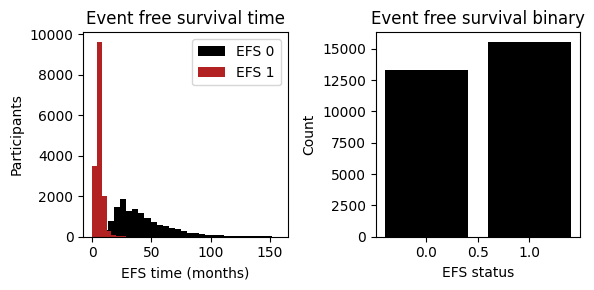

Raw data shape: (28800, 59)


In [2]:
# Load dataset definitions
with open(datasets_definitions_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

print('Datasets:\n')
for description, filepath in datasets.items():
    print(f' {description}')

# Load feature definitions
with open(feature_types_dict_file, 'rb') as input_file:
    feature_types=pickle.load(input_file)

print('\nFeature types:\n')
for feature_type, features in feature_types.items():
    print(f' {feature_type}: {features}\n')

# Load the data
data_df_file=datasets['All ordinal encoded, NAN imputed']
raw_data_df=pd.read_parquet(data_df_file)

# Take a quick look at the target
efs_neg_df=raw_data_df[raw_data_df['efs'] == 0]
efs_pos_df=raw_data_df[raw_data_df['efs'] == 1]

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(6,3))
axs=axs.flatten()

axs[0].set_title('Event free survival time')
axs[0].hist(efs_neg_df['efs_time'], bins=30, color='black', label='EFS 0')
axs[0].hist(efs_pos_df['efs_time'], bins=30, color='firebrick', label='EFS 1')
axs[0].set_xlabel('EFS time (months)')
axs[0].set_ylabel('Participants')
axs[0].legend(loc='upper right')

axs[1].set_title('Event free survival binary')
axs[1].bar(raw_data_df['efs'].value_counts().index, raw_data_df['efs'].value_counts(), color='black')
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f'Raw data shape: {raw_data_df.shape}')

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28800 entries, 0 to 28799
Data columns (total 59 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   psych_disturb           28800 non-null  int32  
 1   diabetes                28800 non-null  int32  
 2   tbi_status              28800 non-null  int32  
 3   arrhythmia              28800 non-null  int32  
 4   graft_type              28800 non-null  int32  
 5   vent_hist               28800 non-null  int32  
 6   renal_issue             28800 non-null  int32  
 7   pulm_severe             28800 non-null  int32  
 8   prim_disease_hct        28800 non-null  int32  
 9   tce_imm_match           28800 non-null  int32  
 10  rituximab               28800 non-null  int32  
 11  prod_type               28800 non-null  int32  
 12  conditioning_intensity  28800 non-null  int32  
 13  ethnicity               28800 non-null  int32  
 14  obesity                 28800 non-null  int

## 2. Data preparation

### 2.1. Train-test split

In [4]:
training_df, testing_df=train_test_split(raw_data_df, test_size=0.33, random_state=315)

training_labels_df=training_df[['efs', 'efs_time']]
training_features_df=training_df.drop(['efs', 'efs_time'], axis=1)

testing_labels_df=testing_df[['efs', 'efs_time']]
testing_features_df=testing_df.drop(['efs', 'efs_time'], axis=1)

### 2.2. Save and remove training & testing race group

In [5]:
training_race_group=training_df['race_group']
testing_race_group=testing_df['race_group']

training_df.drop('race_group', axis=1, inplace=True)
testing_df.drop('race_group', axis=1, inplace=True)

## 3. Cox proportional hazards model

### 3.1. Naive model

In [6]:
cph_model=CoxPHFitter()
cph_model.fit(training_df, duration_col='efs_time', event_col='efs')

<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>

### 3.2. Feature p-values

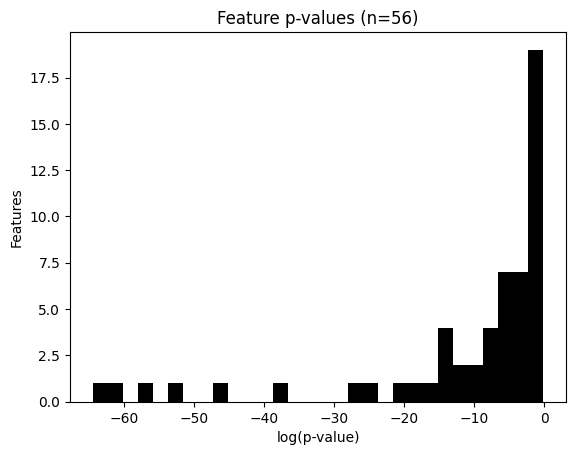

Significant features at alpha = 0.05: 33
Significant features at alpha = 0.001: 23


In [7]:
feature_pvals=cph_model.summary['p']

plt.title(f'Feature p-values (n={len(feature_pvals)})')
plt.hist(np.log(feature_pvals), color='black', bins=30)
plt.xlabel('log(p-value)')
plt.ylabel('Features')
plt.show()

significant_features=feature_pvals[feature_pvals < 0.05]
print(f'Significant features at alpha = 0.05: {len(significant_features)}')

significant_features=feature_pvals[feature_pvals < 0.001]
print(f'Significant features at alpha = 0.001: {len(significant_features)}')

### 3.3. Feature selection

In [8]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

### 3.4. Model re-training

In [9]:
training_significant_features_df=training_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
testing_significant_features_df=testing_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()

training_significant_features_df['efs']=training_df['efs']
training_significant_features_df['efs_time']=training_df['efs_time']
testing_significant_features_df['efs']=testing_df['efs']
testing_significant_features_df['efs_time']=testing_df['efs_time']

cph_model=CoxPHFitter()
cph_model.fit(training_significant_features_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 19296
number of events observed = 10420
   partial log-likelihood = -98098.73
         time fit was run = 2025-02-23 16:11:19 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
psych_disturb           0.07      1.07      0.01            0.04            0.10                1.04                1.10
diabetes                0.06      1.06      0.01            0.04            0.09                1.04                1.09
tbi_status             -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
graft_type             -0.23      0.80      0.05           -0.32           -0.13                0.73                0.87
pulm_severe             0.12      1.12      0.02            0.08            0.15                1.08                1.16
prim_disease_hct       -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
prod_type               0.16      1.17      0.05            0.07            0.25                1.07                1.29
conditioning_intensity  0.03      1.03      0.01            0.02            0.05                1.02                1.05
in_vivo_tcd            -0.11      0.89      0.01           -0.14           -0.09                0.87                0.91
hepatic_severe         -0.17      0.84      0.02           -0.22           -0.12                0.81                0.88
sex_match              -0.03      0.97      0.01           -0.05           -0.02                0.95                0.98
donor_related          -0.07      0.93      0.01           -0.09           -0.05                0.91                0.95
cardiac                 0.11      1.12      0.02            0.07            0.15                1.08                1.16
pulm_moderate           0.04      1.04      0.01            0.01            0.06                1.01                1.07
hla_match_dqb1_low      0.17      1.19      0.02            0.13            0.21                1.13                1.24
year_hct               -0.04      0.96      0.00           -0.04           -0.03                0.96                0.97
hla_match_a_low        -0.16      0.86      0.02           -0.20           -0.11                0.82                0.89
comorbidity_score       0.04      1.05      0.00            0.04            0.05                1.04                1.05
karnofsky_score        -0.05      0.95      0.01           -0.06           -0.04                0.94                0.96
hla_low_res_10         -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
dri_score               0.06      1.06      0.01            0.05            0.07                1.05                1.07
donor_age               0.00      1.00      0.00            0.00            0.00                1.00                1.00
age_at_hct              0.01      1.01      0.00            0.01            0.01                1.01                1.01

                        cmp to      z      p  -log2(p)
covariate                                             
psych_disturb             0.00   4.78 <0.005     19.11
diabetes                  0.00   4.67 <0.005     18.33
tbi_status                0.00  -4.81 <0.005     19.32
graft_type                0.00  -4.80 <0.005     19.28
pulm_severe               0.00   6.28 <0.005     31.48
prim_disease_hct          0.00  -6.04 <0.005     29.24
prod_type                 0.00   3.43 <0.005     10.69
conditioning_intensity    0.00   3.92 <0.005     13.47
in_vivo_tcd               0.00  -9.57 <0.005     69.72
h

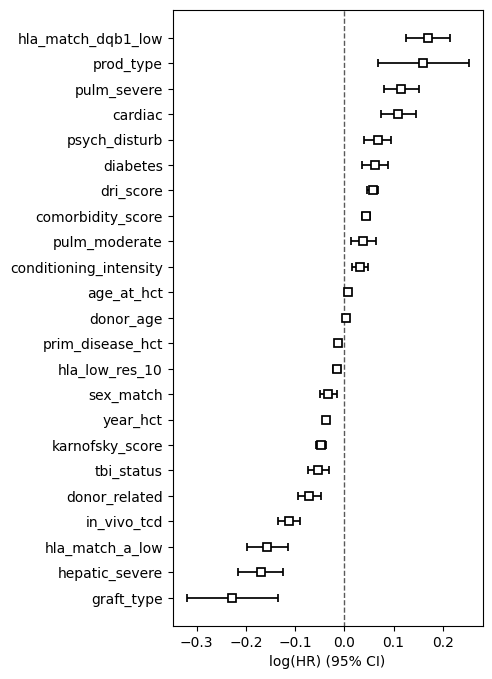

In [10]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

In [11]:
cph_model.check_assumptions(training_significant_features_df, p_value_threshold=feature_pval_cutoff)

The ``p_value_threshold`` is set at 0.001. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 19296 total observations, 8876 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
age_at_hct             km             40.79 <0.005     32.46
                       rank           40.88 <0.005     32.53
cardiac                km              0.02   0.88      0.18
                       rank            0.02   0.88      0.19
comorbidity_score      km             54.88 <0.005     42.82
                       rank           55.11 <0.005     42.99
conditioning_intensity km              7.65   0.01      7.46
                       rank            7.64   0.01      7.45
diabetes               km              8.71 <0.005      8.30
                       rank            8.71 <0.005      8.30
donor_age              km             81.44 <0.005     62.26
                       rank           81.47 <0.005     62.29
donor_related          km             53.77 <0.005     42.02
                       rank           53.75 <0.005     42.00
dri_score              km             71.48 <0.005     54.99
                       rank           71.50 <0.005     55.00
graft_type             km              9.19 <0.005      8.68
                       rank            9.18 <0.005      8.67
hepatic_severe         km             14.89 <0.005     13.10
                       rank           14.94 <0.005     13.14
hla_low_res_10         km             59.58 <0.005     46.27
                       rank           59.65 <0.005     46.33
hla_match_a_low        km             41.61 <0.005     33.06
                       rank           41.60 <0.005     33.06
hla_match_dqb1_low     km             28.74 <0.005     23.52
                       rank           28.73 <0.005     23.52
in_vivo_tcd            km            225.58 <0.005    166.96
                       rank          225.52 <0.005    166.92
karnofsky_score        km              3.33   0.07      3.88
                       rank            3.34   0.07      3.89
prim_disease_hct       km             29.29 <0.005     23.94
                       rank           29.33 <0.005     23.96
prod_type              km              0.06   0.81      0.30
                       rank            0.06   0.81      0.30
psych_disturb          km              0.04   0.84      0.26
                       rank            0.04   0.83      0.26
pulm_moderate          km              0.08   0.78      0.35
                       rank            0.08   0.78      0.36
pulm_severe            km             17.68 <0.005     15.23
                       rank           17.69 <0.005     15.23
sex_match              km             39.83 <0.005     31.75
                       rank           39.81 <0.005     31.73
tbi_status             km              0.38   0.54      0.90
                       rank            0.38   0.54      0.90
year_hct               km             62.43 <0.005     48.36
                       rank           62.23 <0.005     48.22



1. Variable 'diabetes' failed the non-proportional test: p-value is 0.0032.

   Advice: with so few unique values (only 3), you can include `strata=['diabetes', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'graft_type' failed the non-proportional test: p-value is 0.0024.

   Advice: with so few unique values (only 2), you can include `strata=['graft_type', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable 'pulm_severe' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 3), you can include `strata=['pulm_severe', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable 'prim_disease_hct' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'prim_disease_hct' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. 

[]

## 4. Survival forecasting

In [12]:
# Predict new survival function for all subjects
training_survival_functions=cph_model.predict_survival_function(training_significant_features_df)
training_partial_hazards=cph_model.predict_partial_hazard(training_significant_features_df)
training_survival_df=training_labels_df[['efs', 'efs_time']].copy()
training_survival_df['Survival']=training_survival_functions.iloc[-1]
training_survival_df['Partial hazard']=training_partial_hazards

# Predict new survival function for all subjects
testing_survival_functions=cph_model.predict_survival_function(testing_significant_features_df)
testing_partial_hazards=cph_model.predict_partial_hazard(testing_significant_features_df)
testing_survival_df=testing_labels_df[['efs', 'efs_time']].copy()
testing_survival_df['Survival']=testing_survival_functions.iloc[-1]
testing_survival_df['Partial hazard']=testing_partial_hazards

training_survival_df.head()

,efs,efs_time,Survival,Partial hazard
ID,,,,
1044,1.0,10.592,0.449708,1.047422
9306,0.0,40.171,0.688107,0.489938
24307,1.0,6.128,0.645960,0.572781
1058,0.0,125.803,0.144152,2.538596
24177,0.0,39.575,0.751879,0.373774


### 4.1. Survival curves

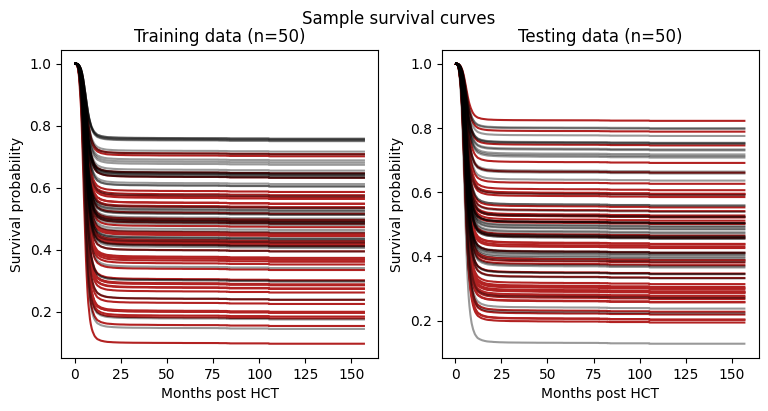

In [13]:
n_curves=50

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

fig.suptitle('Sample survival curves')

efs_positive_ids=training_significant_features_df[training_significant_features_df['efs'] == 1].index
efs_negative_ids=training_significant_features_df[training_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=training_survival_functions[efs_negative_ids]
efs_positive_survival_functions=training_survival_functions[efs_positive_ids]

axs[0].set_title(f'Training data (n={n_curves})')

for i in range(n_curves):
    axs[0].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[0].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[0].set_xlabel('Months post HCT')
axs[0].set_ylabel('Survival probability')

efs_positive_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 1].index
efs_negative_ids=testing_significant_features_df[testing_significant_features_df['efs'] == 0].index

efs_negative_survival_functions=testing_survival_functions[efs_negative_ids]
efs_positive_survival_functions=testing_survival_functions[efs_positive_ids]

axs[1].set_title(f'Testing data (n={n_curves})')

for i in range(n_curves):
    axs[1].plot(efs_positive_survival_functions.index, efs_positive_survival_functions.iloc[:,i], color='firebrick', label='EFS 1')

for i in range(n_curves):
    axs[1].plot(efs_negative_survival_functions.index, efs_negative_survival_functions.iloc[:,i], color='black', alpha=0.4, label='EFS 0')

axs[1].set_xlabel('Months post HCT')
axs[1].set_ylabel('Survival probability')

plt.show()

### 4.2. Survival probability at study end

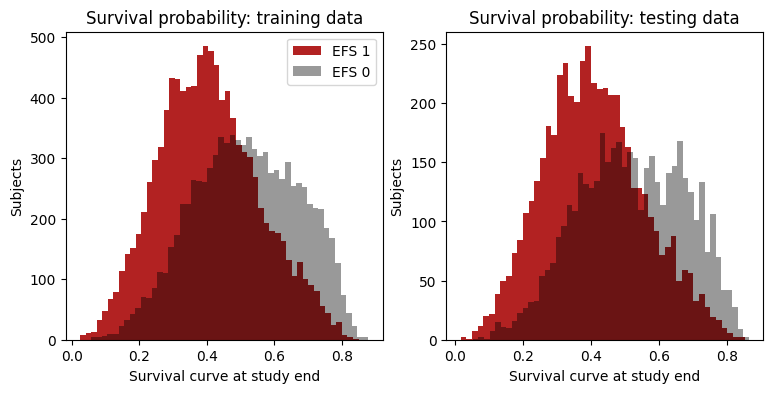

In [14]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Survival probability: training data')
axs[0].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Survival curve at study end')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Survival probability: testing data')
axs[1].hist(efs_positive_df['Survival'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Survival'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Survival curve at study end')
axs[1].set_ylabel('Subjects')

plt.show()

### 4.3. Partial hazard

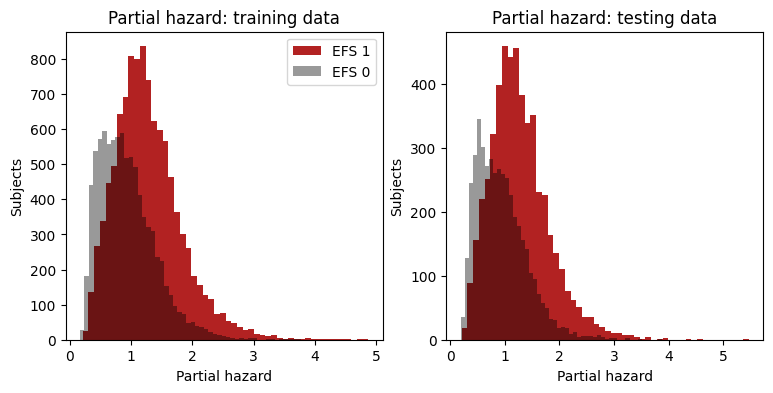

In [15]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(9,4))
axs=axs.flatten()

efs_positive_df=training_survival_df[training_survival_df['efs'] == 1]
efs_negative_df=training_survival_df[training_survival_df['efs'] == 0]

axs[0].set_title('Partial hazard: training data')
axs[0].hist(efs_positive_df['Partial hazard'], bins=50, color='firebrick', label='EFS 1')
axs[0].hist(efs_negative_df['Partial hazard'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[0].set_xlabel('Partial hazard')
axs[0].set_ylabel('Subjects')
axs[0].legend(loc='best')

efs_positive_df=testing_survival_df[testing_survival_df['efs'] == 1]
efs_negative_df=testing_survival_df[testing_survival_df['efs'] == 0]

axs[1].set_title('Partial hazard: testing data')
axs[1].hist(efs_positive_df['Partial hazard'], bins=50, color='firebrick', label='EFS 1')
axs[1].hist(efs_negative_df['Partial hazard'], bins=50, color='black', alpha=0.4, label='EFS 0')
axs[1].set_xlabel('Partial hazard')
axs[1].set_ylabel('Subjects')

plt.show()

### 4.4. C-index scoring

In [16]:
scoring_results=helper_funcs.score_predictions(
    'CoxPH survival',
    testing_survival_df['Survival'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    testing_race_group,
    testing_survival_df.index
)

scoring_results=helper_funcs.score_predictions(
    'CoxPH partial hazard',
    -testing_survival_df['Partial hazard'].values,
    testing_survival_df['efs_time'].values,
    testing_survival_df['efs'].values,
    testing_race_group,
    testing_survival_df.index,
    results=scoring_results
)

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head()

,Model,RMSE,C-index,Stratified C-index
0,CoxPH survival,33.553218,0.627817,0.615916
1,CoxPH partial hazard,34.600372,0.627817,0.615916


## 5. Save survival features

### 5.1. Prep. complete dataset for Cox-PH regression

In [17]:
efs_time=raw_data_df['efs_time']
efs=raw_data_df['efs']
raw_data_df=raw_data_df[feature_pvals[feature_pvals < feature_pval_cutoff].index].copy()
raw_data_df['efs_time']=efs_time
raw_data_df['efs']=efs

### 5.2. Fit Cox PH model

In [18]:
cph_model=CoxPHFitter()
cph_model.fit(raw_data_df, duration_col='efs_time', event_col='efs')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 28800 total observations, 13268 right-censored observations>
             duration col = 'efs_time'
                event col = 'efs'
      baseline estimation = breslow
   number of observations = 28800
number of events observed = 15532
   partial log-likelihood = -152441.82
         time fit was run = 2025-02-23 16:11:43 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                               
psych_disturb           0.06      1.07      0.01            0.04            0.09                1.04                1.09
diabetes                0.05      1.05      0.01            0.03            0.07                1.03                1.08
tbi_status             -0.05      0.96      0.01           -0.06           -0.03                0.94                0.97
graft_type             -0.22      0.81      0.04           -0.29           -0.14                0.75                0.87
pulm_severe             0.12      1.13      0.02            0.09            0.15                1.10                1.17
prim_disease_hct       -0.01      0.99      0.00           -0.02           -0.01                0.98                0.99
prod_type               0.20      1.23      0.04            0.13            0.28                1.14                1.32
conditioning_intensity  0.03      1.03      0.01            0.02            0.05                1.02                1.05
in_vivo_tcd            -0.11      0.90      0.01           -0.13           -0.09                0.88                0.92
hepatic_severe         -0.19      0.83      0.02           -0.23           -0.15                0.80                0.86
sex_match              -0.03      0.97      0.01           -0.04           -0.01                0.96                0.99
donor_related          -0.07      0.94      0.01           -0.08           -0.05                0.92                0.95
cardiac                 0.12      1.13      0.01            0.10            0.15                1.10                1.17
pulm_moderate           0.04      1.04      0.01            0.02            0.06                1.02                1.06
hla_match_dqb1_low      0.16      1.17      0.02            0.12            0.19                1.13                1.21
year_hct               -0.04      0.96      0.00           -0.05           -0.04                0.95                0.96
hla_match_a_low        -0.15      0.86      0.02           -0.18           -0.11                0.84                0.90
comorbidity_score       0.04      1.04      0.00            0.04            0.05                1.04                1.05
karnofsky_score        -0.05      0.95      0.00           -0.05           -0.04                0.95                0.96
hla_low_res_10         -0.02      0.98      0.00           -0.02           -0.01                0.98                0.99
dri_score               0.05      1.06      0.00            0.04            0.06                1.05                1.07
donor_age               0.00      1.00      0.00            0.00            0.00                1.00                1.00
age_at_hct              0.01      1.01      0.00            0.01            0.01                1.01                1.01

                        cmp to      z      p  -log2(p)
covariate                                             
psych_disturb             0.00   5.60 <0.005     25.48
diabetes                  0.00   4.79 <0.005     19.19
tbi_status                0.00  -5.00 <0.005     20.76
graft_type                0.00  -5.65 <0.005     25.90
pulm_severe               0.00   8.25 <0.005     52.54
prim_disease_hct          0.00  -8.28 <0.005     52.90
prod_type                 0.00   5.38 <0.005     23.69
conditioning_intensity    0.00   5.08 <0.005     21.33
in_vivo_tcd               0.00 -11.17 <0.005     93.83

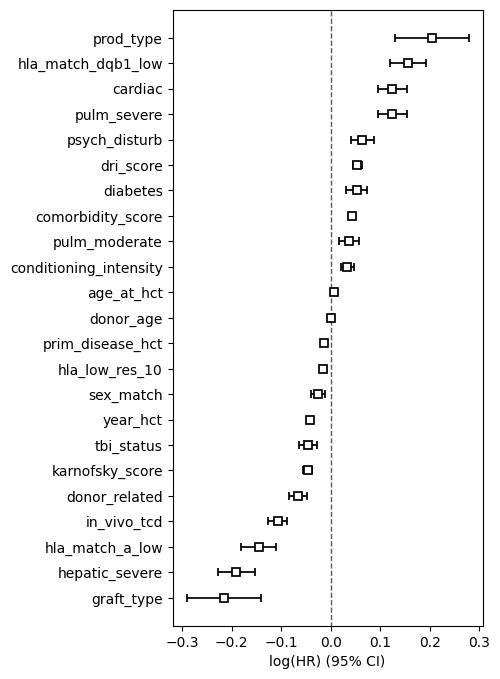

In [19]:
fig=plt.figure(figsize=[4,8])
cph_model.plot(figure=fig)
plt.show()

### 5.3. Get study end survival probabilities

In [20]:
survival_functions=cph_model.predict_survival_function(raw_data_df)
survival_probabilities=survival_functions.iloc[-1]

### 5.4. Get partial hazards

In [21]:
partial_hazards=cph_model.predict_partial_hazard(raw_data_df)

### 5.5. Save predicted survival curves & probabilities

In [22]:
results_df=pd.DataFrame.from_dict({'Survival': survival_probabilities, 'Partial hazard': partial_hazards})
results_df.index=raw_data_df.index
results_df.to_parquet(survival_probabilities_file)
results_df.head()

,Survival,Partial hazard
ID,,
0,0.740311,0.394220
1,0.224012,1.961444
2,0.753316,0.371389
3,0.474416,0.977630
4,0.616655,0.633834
